# Лабораторна робота 5
## Глибокі генеративні моделі
### Щербакова Валерія, ФІ-71
Part 1 dataset: https://www.manythings.org/anki/ (Russian - English rus-eng.zip (438015))

In [23]:
import random, string, re, numpy as np, tensorflow as tf, codecs, matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization

# 1. Генерація послідовностей

Вирішіть завдання генерації послідовностей (архітектура за вашим вибором: seq2seq на основі RNN, або RNN+TeacherForcing, або **Transformer**)
Для навчання можно сгенерувати синтетічні дані (часові ряди), або (що краще) **взяти датасети для машинного перекладу**

Я використовую датасет для машинного перекладу на російську мову та архітектуру Transformer~~s~~.

![Transformer](transformer.jpg "Transformer")

Російська мова взята у зв'язку з великим розміром датасету та можливістю легко зрозуміти наскільки коректний переклад.

In [3]:
text_file = "rus.txt"
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, rus, trash = line.split("\t")
    rus = "[start] " + rus + " [end]"
    text_pairs.append((eng, rus))

In [4]:
for _ in range(5):
    print(random.choice(text_pairs))

('Can you give me another example?', '[start] Вы можете привести мне другой пример? [end]')
('"I am not tired." "Neither am I."', '[start] "Я не устал". - "Я тоже". [end]')
('He fought against racial discrimination.', '[start] Он боролся против расовой дискриминации. [end]')
('Your birthday is coming.', '[start] Приближается твой день рождения. [end]')
("You've got my vote.", '[start] Я отдам свой голос за вас. [end]')


In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

438015 total pairs
306611 training pairs
65702 validation pairs
65702 test pairs


In [6]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

rus_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_rus_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
rus_vectorization.adapt(train_rus_texts)

In [8]:
def format_dataset(eng, rus):
    eng = eng_vectorization(eng)
    rus = rus_vectorization(rus)
    return {"encoder_inputs": eng, "decoder_inputs": rus[:, :-1],}, rus[:, 1:]


def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [9]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [11]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [19]:
epochs = 80  # This should be at least 30 for convergence
# ~ 300 s = 5 min per epoch, 90 -> 6 hours 40 mins + validation ~ 7 hours

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

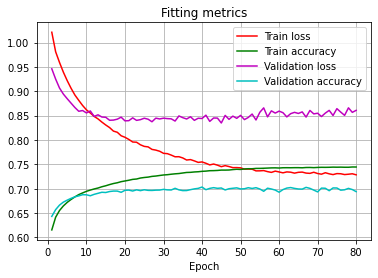

In [24]:
hist = history.history
x = range(1, len(hist['loss']) + 1)

plt.plot(x, hist['loss'], 'r', label='Train loss')
plt.plot(x, hist['accuracy'], 'g', label='Train accuracy')
plt.plot(x, hist['val_loss'], 'm', label='Validation loss')
plt.plot(x, hist['val_accuracy'], 'c', label='Validation accuracy')
plt.title('Fitting metrics')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [28]:
codecs.register_error("strict", codecs.ignore_errors)

rus_vocab = rus_vectorization.get_vocabulary()
rus_index_lookup = dict(zip(range(len(rus_vocab)), rus_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = rus_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = rus_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence + ' -> ' + translated.replace('[UNK]', '___'))

Just wait for us here. -> [start] Просто ___ нас здесь [end]
Are you sure you just want water? -> [start] Ты точно хочешь только воды [end]
Tom went straight to the post office. -> [start] Том пошёл на ___ ___ ___ [end]
I won't bother you again. -> [start] Я вас больше не ___ [end]
Does it hurt? -> [start] Это один свитер [end]
We're closer than we've ever been. -> [start] Мы ___ ___ [end]
Tom still owes Mary 2,000 dollars. -> [start] Том всё ещё должен ___ из ___ Том [end]
Tom raked in money during the war. -> [start] Том ___ в ___ у ___ в ___ [end]
Tom isn't the only person that can do that. -> [start] Том не единственный кто может это сделать [end]
I don't like taking risks. -> [start] Я не люблю ___ [end]
You need to pay your bills on time. -> [start] Вам нужно заплатить по Тому время [end]
We want time. -> [start] Нам нужно время [end]
Why were you wearing a jacket? -> [start] Почему ты был в ___ [end]
Tom knows how to play the viola. -> [start] Том умеет играть на ___ в ___ [end]

Звісно вийшов не гугл транслейт, але результати досить цікаві. Також по графікам видно що після 20-25 епохи подальше навчання не має сенсу оскільки метрики на перевірочній вибірці не покращуються. Я вибрала таку кількість епох бо залишала підрахунок на ніч щоб я могла проспостерігати цю динаміку.

Для покращення перекладу, можливо, слід збільшувати розмірності мережі та розмір словника, проте, мережа й так дуже довго навчалася, тому, я вважаю, для лабораторної роботи результати досить непогані.

# 2. Генерація зображень
Вирішіть завдання генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/CVAE), якщо в обраному датасеті багато класів, залиште декілька

# Реалізовано в іншому файлі: [Laba5-2.ipynb]().